100%|██████████| 1000/1000 [01:22<00:00, 12.08it/s]


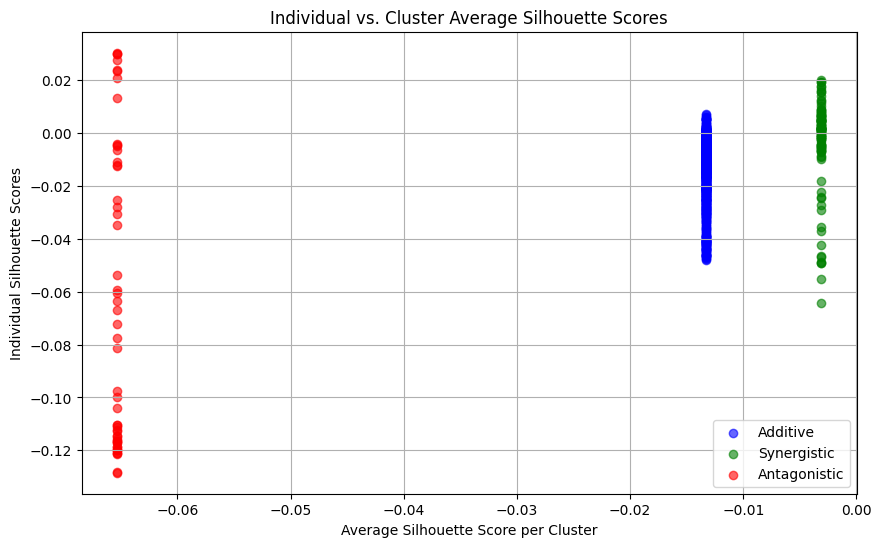

In [24]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Initialization of tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states[-1]
    sentence_embedding = torch.mean(hidden_states, dim=1)
    return sentence_embedding.detach().numpy().flatten()

# Load data
final_reduced_df = pd.read_csv('final_reduced.csv').head(1000)
label_to_index = {'Additive': 0, 'Synergistic': 1, 'Antagonistic': 2}
int_labels = final_reduced_df['Prediction'].map(label_to_index).values

# Extract drug names using regex from 'Prompt'
regex = r"The drug combination to analyze is: ([^.]+)\."
final_reduced_df['Extracted Drug Names'] = final_reduced_df['Prompt'].apply(lambda x: re.search(regex, x).group(1) if re.search(regex, x) else '')

# Filter out rows without extracted names
filtered_df = final_reduced_df[final_reduced_df['Extracted Drug Names'].str.len() > 0]

# Generate embeddings
embeddings = [get_embeddings(drug_names) for drug_names in tqdm(filtered_df['Extracted Drug Names'])]
embeddings_np = np.array(embeddings)

# Update int_labels to match the filtered dataframe
int_labels = filtered_df['Prediction'].map(label_to_index).values

# t-SNE reduction
tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings_np) - 1))
embeddings_2d = tsne.fit_transform(embeddings_np)

# Compute silhouette scores
individual_silhouette_values = silhouette_samples(embeddings_np, int_labels)

# Mapping from cluster label to average silhouette score
average_silhouette_scores = {label: np.mean(individual_silhouette_values[int_labels == idx]) for label, idx in label_to_index.items()}

# Prepare data for plotting
average_scores_per_sample = [average_silhouette_scores[label] for label in filtered_df['Prediction']]
valid_individual_scores = individual_silhouette_values.tolist()

# Plotting individual vs. cluster average silhouette scores
plt.figure(figsize=(10, 6))
for label_type, color in zip(label_to_index.keys(), ['blue', 'green', 'red']):
    cluster_indices = int_labels == label_to_index[label_type]
    plt.scatter(
        [average_silhouette_scores[label_type]] * np.sum(cluster_indices), 
        individual_silhouette_values[cluster_indices],
        color=color,
        label=label_type,
        alpha=0.6
    )

plt.title('Individual vs. Cluster Average Silhouette Scores')
plt.xlabel('Average Silhouette Score per Cluster')
plt.ylabel('Individual Silhouette Scores')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# Count the occurrences of each label in the Prediction column
label_counts = final_reduced_df['Prediction'].value_counts()

# Print the counts of each label
print(label_counts)


Prediction
Additive        838
Synergistic     110
Antagonistic     52
Name: count, dtype: int64
